1. Загрузка и объединение текстовых признаков

In [23]:
import pandas as pd

# Загрузка CSV
df = pd.read_csv("Dataset_Malawi_National_Football_Team_Matches.csv")

# Объединяем категориальные текстовые колонки в один текстовый столбец
df["text"] = df[["Opponent", "Result", "Venue", "Competition"]].fillna("").agg(" ".join, axis=1)
texts = df["text"].tolist()


2. Подготовка функций токенизации

In [24]:
import re
from collections import defaultdict

def tokenize(doc):
    return (tok.lower() for tok in re.findall(r"\w+", doc))

def token_freqs(doc):
    freq = defaultdict(int)
    for tok in tokenize(doc):
        freq[tok] += 1
    return freq


3. Сравнение методов векторизации

In [25]:
from sklearn.feature_extraction import DictVectorizer, FeatureHasher
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
import numpy as np
from time import time

def n_nonzero_columns(X):
    return len(np.unique(X.nonzero()[1]))

data_size_mb = sum(len(s.encode("utf-8")) for s in texts) / 1e6
vectorizer_stats = defaultdict(list)

# DictVectorizer
t0 = time()
dv = DictVectorizer()
X_dv = dv.fit_transform(token_freqs(d) for d in texts)
duration = time() - t0
vectorizer_stats["vectorizer"].append("DictVectorizer")
vectorizer_stats["speed"].append(data_size_mb / duration)
print(f"DictVectorizer: {X_dv.shape} — {duration:.2f}s")

# FeatureHasher
t0 = time()
fh = FeatureHasher(n_features=2**12)
X_fh = fh.transform(token_freqs(d) for d in texts)
duration = time() - t0
vectorizer_stats["vectorizer"].append("FeatureHasher")
vectorizer_stats["speed"].append(data_size_mb / duration)
print(f"FeatureHasher: {X_fh.shape} — {duration:.2f}s")

# CountVectorizer
t0 = time()
cv = CountVectorizer()
X_cv = cv.fit_transform(texts)
duration = time() - t0
vectorizer_stats["vectorizer"].append("CountVectorizer")
vectorizer_stats["speed"].append(data_size_mb / duration)
print(f"CountVectorizer: {X_cv.shape} — {duration:.2f}s")

# HashingVectorizer
t0 = time()
hv = HashingVectorizer(n_features=2**12)
X_hv = hv.fit_transform(texts)
duration = time() - t0
vectorizer_stats["vectorizer"].append("HashingVectorizer")
vectorizer_stats["speed"].append(data_size_mb / duration)
print(f"HashingVectorizer: {X_hv.shape} — {duration:.2f}s")

# TfidfVectorizer
t0 = time()
tv = TfidfVectorizer()
X_tv = tv.fit_transform(texts)
duration = time() - t0
vectorizer_stats["vectorizer"].append("TfidfVectorizer")
vectorizer_stats["speed"].append(data_size_mb / duration)
print(f"TfidfVectorizer: {X_tv.shape} — {duration:.2f}s")


DictVectorizer: (73, 70) — 0.00s
FeatureHasher: (73, 4096) — 0.00s
CountVectorizer: (73, 69) — 0.00s
HashingVectorizer: (73, 4096) — 0.00s
TfidfVectorizer: (73, 69) — 0.00s


4. Визуализация сравнения

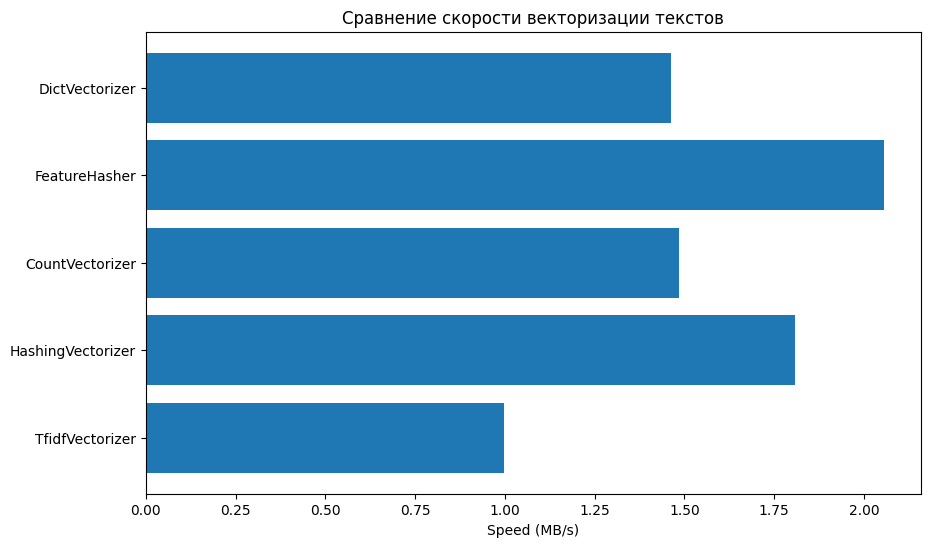

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(vectorizer_stats["vectorizer"]))
ax.barh(y_pos, vectorizer_stats["speed"], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(vectorizer_stats["vectorizer"])
ax.invert_yaxis()
ax.set_xlabel("Speed (MB/s)")
ax.set_title("Сравнение скорости векторизации текстов")
plt.show()


Задание успешно выполнено. Самым быстрым оказался FeatureHasher, потому что он получил уже подготовленные словари, не делал никакой токенизации и разбора текста, а просто хешировал ключи - это очень быстро, тк это всего один проход по словарю.